# Medicare Fraud Detection

In [1]:
# importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import sum, mean, max, col 
from pyspark.sql.functions import upper
from pyspark.sql.functions import monotonically_increasing_id

### Create a SparkSession

In [2]:
spark = SparkSession.builder.appName("Medicare data").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/09 18:37:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
sc = spark.sparkContext
sc.setLogLevel("ERROR")

### Using 3 data sets for this project and merging at the end

### 1. Data by provider and Drug

In [4]:
# Read the CSV file into a spark DataFrame
df = spark.read.csv('/Users/tejapeddi/Documents/cs649/Medicare Part D Prescribers - by Provider and Drug/2020.csv', header=True, inferSchema=True)
df.show(5)

+-----------+---------------------+------------------+------------+--------------------+------------------+-----------------+----------------+--------------------+--------------------+--------+---------------+-------------+------------+---------+---------------+-------------+--------------------+-----------------+------------------+--------------------+--------------+
|Prscrbr_NPI|Prscrbr_Last_Org_Name|Prscrbr_First_Name|Prscrbr_City|Prscrbr_State_Abrvtn|Prscrbr_State_FIPS|     Prscrbr_Type|Prscrbr_Type_Src|           Brnd_Name|           Gnrc_Name|Tot_Clms|Tot_30day_Fills|Tot_Day_Suply|Tot_Drug_Cst|Tot_Benes|GE65_Sprsn_Flag|GE65_Tot_Clms|GE65_Tot_30day_Fills|GE65_Tot_Drug_Cst|GE65_Tot_Day_Suply|GE65_Bene_Sprsn_Flag|GE65_Tot_Benes|
+-----------+---------------------+------------------+------------+--------------------+------------------+-----------------+----------------+--------------------+--------------------+--------+---------------+-------------+------------+---------+------------

In [5]:
# printing the columns of the data frame
df.columns

['Prscrbr_NPI',
 'Prscrbr_Last_Org_Name',
 'Prscrbr_First_Name',
 'Prscrbr_City',
 'Prscrbr_State_Abrvtn',
 'Prscrbr_State_FIPS',
 'Prscrbr_Type',
 'Prscrbr_Type_Src',
 'Brnd_Name',
 'Gnrc_Name',
 'Tot_Clms',
 'Tot_30day_Fills',
 'Tot_Day_Suply',
 'Tot_Drug_Cst',
 'Tot_Benes',
 'GE65_Sprsn_Flag',
 'GE65_Tot_Clms',
 'GE65_Tot_30day_Fills',
 'GE65_Tot_Drug_Cst',
 'GE65_Tot_Day_Suply',
 'GE65_Bene_Sprsn_Flag',
 'GE65_Tot_Benes']

In [6]:
# Create new DataFrame 1 with specific columns
new_df1 = df.select("Prscrbr_NPI", "Brnd_Name", "Tot_Drug_Cst", "Tot_Clms", "Tot_Day_Suply", "Prscrbr_Type")

# Create new DataFrame 2 with specific columns
new_df2 = df.select("Prscrbr_NPI", "Prscrbr_First_Name", "Prscrbr_Last_Org_Name", "Prscrbr_City", "Prscrbr_State_Abrvtn", "Prscrbr_Type")

In [7]:
new_df1 = new_df1.dropna()
new_df2 = new_df2.dropna()

In [8]:
new_df2 = new_df2.drop_duplicates()

In [9]:
# Rename columns in new_df1
new_df1 = new_df1.withColumnRenamed("Prscrbr_NPI", "npi") \
                 .withColumnRenamed("Brnd_Name", "drug_name") \
                 .withColumnRenamed("Tot_Drug_Cst", "total_drug_cost") \
                 .withColumnRenamed("Tot_Clms", "total_claims") \
                 .withColumnRenamed("Tot_Day_Suply", "total_day_supply") \
                 .withColumnRenamed("Prscrbr_Type", "specialty_description")


In [10]:
# Rename columns in new_df2
new_df2 = new_df2.withColumnRenamed("Prscrbr_NPI", "npi") \
                 .withColumnRenamed("Prscrbr_First_Name", "first_name") \
                 .withColumnRenamed("Prscrbr_Last_Org_Name", "last_name") \
                 .withColumnRenamed("Prscrbr_City", "city") \
                 .withColumnRenamed("Prscrbr_State_Abrvtn", "state") \
                 .withColumnRenamed("Prscrbr_Type", "specialty_description")


In [11]:
new_df1.show(5)

+----------+--------------------+---------------+------------+----------------+---------------------+
|       npi|           drug_name|total_drug_cost|total_claims|total_day_supply|specialty_description|
+----------+--------------------+---------------+------------+----------------+---------------------+
|1003000126| Amlodipine Besylate|          59.21|          13|             390|    Internal Medicine|
|1003000126|Atorvastatin Calcium|         259.48|          27|             765|    Internal Medicine|
|1003000126|          Cephalexin|          98.99|          17|             123|    Internal Medicine|
|1003000126|   Ciprofloxacin Hcl|         120.43|          12|              95|    Internal Medicine|
|1003000126| Doxycycline Hyclate|         300.76|          17|             105|    Internal Medicine|
+----------+--------------------+---------------+------------+----------------+---------------------+
only showing top 5 rows



In [12]:
new_df2.show(5)

+----------+------------+---------+----------+-----+---------------------+
|       npi|  first_name|last_name|      city|state|specialty_description|
+----------+------------+---------+----------+-----+---------------------+
|1003012014|Keith-Austin|   Scarfo|Providence|   RI|       Anesthesiology|
|1003014374|     Michael| Connolly|  Riverton|   UT| Psychiatry & Neur...|
|1003015785|        Ryan|   Rogers|   Houston|   TX|        Ophthalmology|
|1003019902|     Lealani|   Acosta| Nashville|   TN|            Neurology|
|1003023029|    Takehiro| Kasahara|  New York|   NY| Oral Surgery (Den...|
+----------+------------+---------+----------+-----+---------------------+
only showing top 5 rows



In [13]:
# creating new features from the exixting features
desc_df=new_df1.groupBy(col('npi')) \
            .agg(sum(col('total_drug_cost')).alias('sum_of_total_drug_cost'), \
                mean(col('total_drug_cost')).alias('mean_of_total_drug_cost'), \
                max(col('total_drug_cost')).alias('max_of_total_drug_cost'), \
                sum(col('total_claims')).alias('sum_of_total_claims'), \
                mean(col('total_claims')).alias('mean_of_total_claims'), \
                max(col('total_claims')).alias('max_of_total_claims'), \
                sum(col('total_day_supply')).alias('sum_of_total_day_supply'), \
                mean(col('total_day_supply')).alias('mean_of_total_day_supply'), \
                max(col('total_day_supply')).alias('max_of_total_day_supply'))
desc_df.show(10)


+----------+----------------------+-----------------------+----------------------+-------------------+--------------------+-------------------+-----------------------+------------------------+-----------------------+
|       npi|sum_of_total_drug_cost|mean_of_total_drug_cost|max_of_total_drug_cost|sum_of_total_claims|mean_of_total_claims|max_of_total_claims|sum_of_total_day_supply|mean_of_total_day_supply|max_of_total_day_supply|
+----------+----------------------+-----------------------+----------------------+-------------------+--------------------+-------------------+-----------------------+------------------------+-----------------------+
|1003043209|              33719.36|      1021.798787878788|               11856.4|                978|  29.636363636363637|                 97|                  38834|      1176.7878787878788|                   4794|
|1003072810|    105507.89000000001|     1445.3135616438358|              22965.52|               2509|   34.36986301369863|         

In [14]:
# joining the dataframes
partD_allpd = desc_df.join(new_df2, on='npi', how='left')

In [15]:
#partD_allpd = partD_allpd.drop(col('index'))

In [16]:
partD_allpd = partD_allpd.select([upper(col).alias(col) if col in ['first_name', 'last_name', 'city', 'state', 'drug_name', 'specialty_description'] else col for col in partD_allpd.columns])

In [17]:
partD_allpd = partD_allpd.withColumn("index", monotonically_increasing_id())

In [18]:
partD_allpd.show(10)

+----------+----------------------+-----------------------+----------------------+-------------------+--------------------+-------------------+-----------------------+------------------------+-----------------------+----------+------------+--------------+-----+---------------------+-----+
|       npi|sum_of_total_drug_cost|mean_of_total_drug_cost|max_of_total_drug_cost|sum_of_total_claims|mean_of_total_claims|max_of_total_claims|sum_of_total_day_supply|mean_of_total_day_supply|max_of_total_day_supply|first_name|   last_name|          city|state|specialty_description|index|
+----------+----------------------+-----------------------+----------------------+-------------------+--------------------+-------------------+-----------------------+------------------------+-----------------------+----------+------------+--------------+-----+---------------------+-----+
|1003000423|                8458.5|      1208.357142857143|               4497.46|                 85|  12.142857142857142|       

### 2. payments data

In [19]:
#from pyspark.sql import SparkSession

# Create a SparkSession
#spark = SparkSession.builder.appName("Read CSV").getOrCreate()

# Read the CSV file into a DataFrame
pay_df = spark.read.csv("/Users/tejapeddi/Documents/cs649/PGYR17_P012023/OP_DTL_GNRL_PGYR2021_P01202023.csv", header=True, inferSchema=True)


In [20]:
# Show the first few rows of the DataFrame
pay_df.show(5)

+-----------+----------------------+---------------------+--------------------+----------------------+----------------------------+---------------------+----------------------------+-----------------------------+---------------------------+-----------------------------+-----------------------------------------------+-----------------------------------------------+--------------+---------------+------------------+-----------------+------------------+---------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-------------------------------------+-------------------------------------+-------------------------------------+---------------------------------

In [104]:
pay_df.count()

11417357

In [21]:
#spark = SparkSession.builder.appName("PaymentAnalysis").getOrCreate()

# Select required columns
payment_fpd = pay_df.select(col("Covered_Recipient_First_Name"), \
                                col("Covered_Recipient_Last_Name"), \
                                col("Recipient_City"), \
                                col("Recipient_State"), \
                                col("Total_Amount_of_Payment_USDollars"))

# Show DataFrame
payment_fpd.show()

+----------------------------+---------------------------+---------------+---------------+---------------------------------+
|Covered_Recipient_First_Name|Covered_Recipient_Last_Name| Recipient_City|Recipient_State|Total_Amount_of_Payment_USDollars|
+----------------------------+---------------------------+---------------+---------------+---------------------------------+
|                       NAZEM|                    ABRAHAM|     HUNTINGTON|             WV|                            12.00|
|                     Charles|                        Pak|         Dallas|             TX|                           300.00|
|                       Nazem|                    Abraham|     HUNTINGTON|             WV|                            13.39|
|                       NAZEM|                    ABRAHAM|     HUNTINGTON|             WV|                            13.39|
|                        HANY|                      AHMED|        HOUSTON|             TX|                            12.03|


In [22]:
#drop the null values
payment_fpd.dropna()

DataFrame[Covered_Recipient_First_Name: string, Covered_Recipient_Last_Name: string, Recipient_City: string, Recipient_State: string, Total_Amount_of_Payment_USDollars: string]

In [23]:
#Group the DataFrame by the columns 'Covered_Recipient_First_Name', 'Covered_Recipient_Last_Name', 'Recipient_City', and 'Recipient_State'.
#Aggregate the 'Total_Amount_of_Payment_USDollars' column by taking the sum of its values for each group.
payment_fpd1 = payment_fpd.groupBy(['Covered_Recipient_First_Name', 'Covered_Recipient_Last_Name', 'Recipient_City', 'Recipient_State']) \
                         .agg(sum('Total_Amount_of_Payment_USDollars').alias('Total_Amount_of_Payment_USDollars_sum')) \
                         .withColumnRenamed('Covered_Recipient_First_Name', 'first_name') \
                         .withColumnRenamed('Covered_Recipient_Last_/Name', 'last_name') \
                         .withColumnRenamed('Recipient_City', 'city') \
                         .withColumnRenamed('Recipient_State', 'state')

payment_fpd1 = payment_fpd1.sort('Total_Amount_of_Payment_USDollars_sum', ascending=False)


In [24]:
# Define the new column names
rename_dict = {'Covered_Recipient_First_Name':'First_name', 'Covered_Recipient_Last_Name':'Last_name',
               'Recipient_City':'City','Recipient_State':'State',
               'Total_Amount_of_Payment_USDollars_sum':'Total_Payment_Sum'}

# Rename the columns using the withColumnRenamed() method
payment_fpd1 = payment_fpd1.withColumnRenamed('Covered_Recipient_First_Name', 'first_name') \
                           .withColumnRenamed('Covered_Recipient_Last_Name', 'last_name') \
                           .withColumnRenamed('Recipient_City', 'city') \
                           .withColumnRenamed('Recipient_State', 'state') \
                           .withColumnRenamed('Total_Amount_of_Payment_USDollars_sum', 'Total_Payment_Sum')



In [25]:
payment_fpd1 = payment_fpd1.select([upper(c).alias(c) for c in payment_fpd1.columns])

payment_fpd1.show(5)

+----------+---------+-----------+-----+--------------------+
|first_name|last_name|       city|state|   Total_Payment_Sum|
+----------+---------+-----------+-----+--------------------+
|      null|     null|     DUARTE|   CA|      4.0083734066E8|
|      null|     null|     BOSTON|   MA| 6.548358622000001E7|
|      null|     null|      PHILA|   PA|3.3109343040000007E7|
|     JAMES|   GAMMIE|  BALTIMORE|   MD|2.6843529799999997E7|
|   STEPHEN| BURKHART|SAN ANTONIO|   TX|       2.296924526E7|
+----------+---------+-----------+-----+--------------------+
only showing top 5 rows



In [26]:
#The code adds a new column named "index" to the PySpark DataFrame "payment_fpd1" using the "monotonically_increasing_id()" function.
payment_fpd1 = payment_fpd1.withColumn("index", monotonically_increasing_id())

In [27]:
#perform left join the two dataframes. The join is performed on the columns last_name, first_name, city, and state present in both dataframes. 
pay_partD_fpd = partD_allpd.join(payment_fpd1, on=['last_name','first_name','city','state'], how='left')

In [28]:
pay_partD_fpd.show(10)

+---------+----------+------------+-----+----------+----------------------+-----------------------+----------------------+-------------------+--------------------+-------------------+-----------------------+------------------------+-----------------------+---------------------+-----------+------------------+-----------+
|last_name|first_name|        city|state|       npi|sum_of_total_drug_cost|mean_of_total_drug_cost|max_of_total_drug_cost|sum_of_total_claims|mean_of_total_claims|max_of_total_claims|sum_of_total_day_supply|mean_of_total_day_supply|max_of_total_day_supply|specialty_description|      index| Total_Payment_Sum|      index|
+---------+----------+------------+-----+----------+----------------------+-----------------------+----------------------+-------------------+--------------------+-------------------+-----------------------+------------------------+-----------------------+---------------------+-----------+------------------+-----------+
| BOUCHARD|    DANIEL|     LANSING

In [29]:
#reordering the columns
pay_partD_fpd = pay_partD_fpd.select(col("npi"), col("sum_of_total_drug_cost"), col("mean_of_total_drug_cost"),col("max_of_total_drug_cost"), col("sum_of_total_claims"),col("mean_of_total_claims"), col("max_of_total_claims"),col("sum_of_total_day_supply"), col("mean_of_total_day_supply"),col("max_of_total_day_supply"), col("city"),col("state"),col("last_name"),col("first_name"),col("specialty_description"),col("Total_Payment_Sum"))

In [30]:
pay_partD_fpd.columns

['npi',
 'sum_of_total_drug_cost',
 'mean_of_total_drug_cost',
 'max_of_total_drug_cost',
 'sum_of_total_claims',
 'mean_of_total_claims',
 'max_of_total_claims',
 'sum_of_total_day_supply',
 'mean_of_total_day_supply',
 'max_of_total_day_supply',
 'city',
 'state',
 'last_name',
 'first_name',
 'specialty_description',
 'Total_Payment_Sum']

In [31]:
pay_partD_fpd.dropna()

DataFrame[npi: int, sum_of_total_drug_cost: double, mean_of_total_drug_cost: double, max_of_total_drug_cost: double, sum_of_total_claims: bigint, mean_of_total_claims: double, max_of_total_claims: int, sum_of_total_day_supply: bigint, mean_of_total_day_supply: double, max_of_total_day_supply: int, city: string, state: string, last_name: string, first_name: string, specialty_description: string, Total_Payment_Sum: string]

### 3. LEIE Exclusion Data

In [32]:
#reading the LEIE exlusion dataset
iele_df = spark.read.csv("/Users/tejapeddi/Documents/cs649/UPDATED.csv", header=True, inferSchema=True)
iele_df.show(10)

+--------+---------+-------+--------------------+------------------+--------------+----+----------+----+--------------------+---------+-----+-----+---------+--------+--------+----------+--------+
|LASTNAME|FIRSTNAME|MIDNAME|             BUSNAME|           GENERAL|     SPECIALTY|UPIN|       NPI| DOB|             ADDRESS|     CITY|STATE|  ZIP| EXCLTYPE|EXCLDATE|REINDATE|WAIVERDATE|WVRSTATE|
+--------+---------+-------+--------------------+------------------+--------------+----+----------+----+--------------------+---------+-----+-----+---------+--------+--------+----------+--------+
|    null|     null|       |#1 MARKETING SERV...|    OTHER BUSINESS|    SOBER HOME|null|         0|null|239 BRIGHTON BEAC...| BROOKLYN|   NY|11235|   1128a1|20200319|       0|         0|    null|
|    null|     null|       |101 FIRST CARE PH...|    OTHER BUSINESS|      PHARMACY|null|1972902351|null|C/O 609 W 191ST S...| NEW YORK|   NY|10040|   1128b8|20220320|       0|         0|    null|
|    null|     null|

In [33]:
npifraud_pd0 = iele_df.select('NPI', 'EXCLTYPE')
npifraud_pd0.show(10)

+----------+---------+
|       NPI| EXCLTYPE|
+----------+---------+
|         0|   1128a1|
|1972902351|   1128b8|
|         0|   1128a1|
|         0|   1128b7|
|         0|1128b6   |
|1922348218|   1128a1|
|         0|   1128b5|
|         0|   1128a1|
|         0|   1128b8|
|         0|   1128a1|
+----------+---------+
only showing top 10 rows



In [34]:
npi_fraud_df = npifraud_pd0.filter(npifraud_pd0.NPI != 0)
npi_fraud_df.printSchema()

root
 |-- NPI: integer (nullable = true)
 |-- EXCLTYPE: string (nullable = true)



In [35]:

npi_fraud_df = npi_fraud_df.withColumn("is_fraud", npi_fraud_df["npi"]/npi_fraud_df["npi"] )
npifraud_df1 = npifraud_pd0.filter(col("NPI") != 0).select("NPI", "EXCLTYPE")
rename_dict = {'NPI':'npi', 'EXCLTYPE':'is_fraud'}
npi_fraud_df = npifraud_df1.select([col(c).alias(rename_dict.get(c, c)) for c in npifraud_df1.columns])
npi_fraud_df.show(10)

+----------+--------+
|       npi|is_fraud|
+----------+--------+
|1972902351|  1128b8|
|1922348218|  1128a1|
|1942476080|  1128b8|
|1275600959|  1128a1|
|1891731758|  1128b8|
|1265830335|  1128a1|
|1851631543|  1128b7|
|1902198435|  1128a1|
|1073916631|  1128b7|
|1437510278|  1128a1|
+----------+--------+
only showing top 10 rows



In [36]:
from pyspark.sql.functions import lit
npi_fraud_df = npi_fraud_df.withColumn("is_fraud", lit(1))
npi_fraud_df.show(10)

+----------+--------+
|       npi|is_fraud|
+----------+--------+
|1972902351|       1|
|1922348218|       1|
|1942476080|       1|
|1275600959|       1|
|1891731758|       1|
|1265830335|       1|
|1851631543|       1|
|1902198435|       1|
|1073916631|       1|
|1437510278|       1|
+----------+--------+
only showing top 10 rows



In [37]:
npi_fraud_df = npi_fraud_df.withColumn("npi", col("npi").cast("integer"))
npi_fraud_df.printSchema()

root
 |-- npi: integer (nullable = true)
 |-- is_fraud: integer (nullable = false)



### Features engineering

In [38]:
# Merging the data

Features_df1 = pay_partD_fpd.join(npi_fraud_df.select('npi', 'is_fraud'), on='npi', how='left')
Features_df1.columns

['npi',
 'sum_of_total_drug_cost',
 'mean_of_total_drug_cost',
 'max_of_total_drug_cost',
 'sum_of_total_claims',
 'mean_of_total_claims',
 'max_of_total_claims',
 'sum_of_total_day_supply',
 'mean_of_total_day_supply',
 'max_of_total_day_supply',
 'city',
 'state',
 'last_name',
 'first_name',
 'specialty_description',
 'Total_Payment_Sum',
 'is_fraud']

In [39]:
Features_df1.printSchema()

root
 |-- npi: integer (nullable = true)
 |-- sum_of_total_drug_cost: double (nullable = true)
 |-- mean_of_total_drug_cost: double (nullable = true)
 |-- max_of_total_drug_cost: double (nullable = true)
 |-- sum_of_total_claims: long (nullable = true)
 |-- mean_of_total_claims: double (nullable = true)
 |-- max_of_total_claims: integer (nullable = true)
 |-- sum_of_total_day_supply: long (nullable = true)
 |-- mean_of_total_day_supply: double (nullable = true)
 |-- max_of_total_day_supply: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- specialty_description: string (nullable = true)
 |-- Total_Payment_Sum: string (nullable = true)
 |-- is_fraud: integer (nullable = true)



In [40]:
# filling the null values with 0
Features_df1 = Features_df1.fillna(0)

In [41]:
# counting the the fraud variables
Features_df1.filter(col("is_fraud") == 1).count()

1250

In [42]:
FeaturesAll_df = Features_df1

In [43]:
from pyspark.sql.functions import log10

#Then, it creates three new columns by taking the difference between the max and mean values of total_claims, total_day_supply, and total_drug_cost. These new columns are named claim_max-mean, supply_max-mean, and drug_max-mean, respectively.
FeaturesAll_df = FeaturesAll_df.withColumn('sum_of_total_drug_cost', log10(FeaturesAll_df['sum_of_total_drug_cost'] + 1.0))
FeaturesAll_df = FeaturesAll_df.withColumn('sum_of_total_claims', log10(FeaturesAll_df['sum_of_total_claims'] + 1.0))
FeaturesAll_df = FeaturesAll_df.withColumn('sum_of_total_day_supply', log10(FeaturesAll_df['sum_of_total_day_supply'] + 1.0))
FeaturesAll_df = FeaturesAll_df.withColumn('Total_Payment_Sum', log10(FeaturesAll_df['Total_Payment_Sum'] + 1.0))

FeaturesAll_df = FeaturesAll_df.withColumn('mean_of_total_drug_cost', log10(FeaturesAll_df['mean_of_total_drug_cost'] + 1.0))
FeaturesAll_df = FeaturesAll_df.withColumn('mean_of_total_claims', log10(FeaturesAll_df['mean_of_total_claims'] + 1.0))
FeaturesAll_df = FeaturesAll_df.withColumn('mean_of_total_day_supply', log10(FeaturesAll_df['mean_of_total_day_supply'] + 1.0))

FeaturesAll_df = FeaturesAll_df.withColumn('max_of_total_drug_cost', log10(FeaturesAll_df['max_of_total_drug_cost'] + 1.0))
FeaturesAll_df = FeaturesAll_df.withColumn('max_of_total_claims', log10(FeaturesAll_df['max_of_total_claims'] + 1.0))
FeaturesAll_df = FeaturesAll_df.withColumn('max_of_total_day_supply', log10(FeaturesAll_df['max_of_total_day_supply'] + 1.0))

FeaturesAll_df = FeaturesAll_df.withColumn('claim_max-mean', FeaturesAll_df['max_of_total_claims'] - FeaturesAll_df['mean_of_total_claims'])
FeaturesAll_df = FeaturesAll_df.withColumn('supply_max-mean', FeaturesAll_df['max_of_total_day_supply'] - FeaturesAll_df['mean_of_total_day_supply'])
FeaturesAll_df = FeaturesAll_df.withColumn('drug_max-mean', FeaturesAll_df['max_of_total_drug_cost'] - FeaturesAll_df['mean_of_total_drug_cost'])


In [44]:
FeaturesAll_df.columns

['npi',
 'sum_of_total_drug_cost',
 'mean_of_total_drug_cost',
 'max_of_total_drug_cost',
 'sum_of_total_claims',
 'mean_of_total_claims',
 'max_of_total_claims',
 'sum_of_total_day_supply',
 'mean_of_total_day_supply',
 'max_of_total_day_supply',
 'city',
 'state',
 'last_name',
 'first_name',
 'specialty_description',
 'Total_Payment_Sum',
 'is_fraud',
 'claim_max-mean',
 'supply_max-mean',
 'drug_max-mean']

In [45]:
#drop irrelavent features for modeling 
FeaturesAll_df = FeaturesAll_df.drop("first_name","last_name","state","city","specialty_description")

In [88]:
FeaturesAll_df.printSchema()

root
 |-- npi: integer (nullable = true)
 |-- sum_of_total_drug_cost: double (nullable = true)
 |-- mean_of_total_drug_cost: double (nullable = true)
 |-- max_of_total_drug_cost: double (nullable = true)
 |-- sum_of_total_claims: double (nullable = true)
 |-- mean_of_total_claims: double (nullable = true)
 |-- max_of_total_claims: double (nullable = true)
 |-- sum_of_total_day_supply: double (nullable = true)
 |-- mean_of_total_day_supply: double (nullable = true)
 |-- max_of_total_day_supply: double (nullable = true)
 |-- Total_Payment_Sum: double (nullable = true)
 |-- claim_max-mean: double (nullable = true)
 |-- supply_max-mean: double (nullable = true)
 |-- drug_max-mean: double (nullable = true)
 |-- is_fraud: integer (nullable = true)



In [87]:
# reordering the column names

FeaturesAll_df = FeaturesAll_df.select("npi", "sum_of_total_drug_cost", "mean_of_total_drug_cost","max_of_total_drug_cost", "sum_of_total_claims",
                                                   "mean_of_total_claims","max_of_total_claims", "sum_of_total_day_supply", 
                                                   "mean_of_total_day_supply","max_of_total_day_supply", "Total_Payment_Sum", "claim_max-mean",
                                                  "supply_max-mean", "drug_max-mean", "is_fraud")

In [48]:
# dropping the null vales

FeaturesAll_df = FeaturesAll_df.dropna()

### Oversampling using SMOTE

#### As the data is biassed to class 0 using smote to oversample the data

In [49]:
Features_smote=FeaturesAll_df

In [50]:
from pyspark.ml.feature import VectorAssembler
from imblearn.over_sampling import SMOTE

features = ['npi', 'sum_of_total_drug_cost', 
            'mean_of_total_drug_cost',
            'max_of_total_drug_cost','sum_of_total_claims',
            'mean_of_total_claims','max_of_total_claims',
            'sum_of_total_day_supply','mean_of_total_day_supply',
            'max_of_total_day_supply','Total_Payment_Sum','claim_max-mean','supply_max-mean','drug_max-mean']

label = 'is_fraud'

# Oversample the minority class

smote = SMOTE()
minority_oversampled, minority_oversampled_labels  = smote.fit_resample(Features_smote.select(features).collect(),
                                                                        Features_smote.select(label).collect())


minority_oversampled_df = pd.DataFrame(minority_oversampled, columns=features)


minority_oversampled_df['is_fraud']=minority_oversampled_labels

oversampled_df = spark.createDataFrame(minority_oversampled_df)

In [51]:
# checking the counts of class 1 after oversampling
#oversampled_df.filter(col('is_fraud')==1).count()

In [52]:
#allvars = categorical_features + numerical_features + target

In [53]:
#print(y[:5])
#X.show(10)

## Machine Learning Models

In [54]:
from pyspark.ml import Pipeline
import seaborn as sns
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LinearSVC, NaiveBayes
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [55]:
def classification_report(data,label, model):
    
    """This function will take a spark data frame, label and model as input 
    and returns the classification report and confusion matrix"""

    # Train-Test split
    train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

    # Define the feature columns
    feature_columns = data.columns[:-1]

    # Create a vector assembler
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

    # Initialize the classifiers
    logistic_regression = LogisticRegression(labelCol=label, featuresCol="features")
    random_forest = RandomForestClassifier(labelCol=label, featuresCol="features")
    decision_tree = DecisionTreeClassifier(labelCol=label, featuresCol="features")
    gradient_boosting = GBTClassifier(labelCol=label, featuresCol="features")
    naive_bayes = NaiveBayes(labelCol=label, featuresCol="features")
    svm = LinearSVC(labelCol=label, featuresCol="features")
    
    model = model

    # Create pipelines for each classifier
    
    pipeline = Pipeline(stages=[assembler, model])
    
    results = []

    # Train and evaluate each classifier
    
    # Fit the pipeline on the training data
    model = pipeline.fit(train_data)

    # Make predictions on the test data
    predictions = model.transform(test_data)

    # Evaluate the model's performance
    evaluator = MulticlassClassificationEvaluator(labelCol=label, predictionCol="prediction")
    binary_evaluator = BinaryClassificationEvaluator(labelCol=label, rawPredictionCol="rawPrediction")
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
    
    # Get the predicted and true labels
    predicted = predictions.select('prediction').rdd.flatMap(lambda x: x).collect()
    labels = predictions.select(label).rdd.flatMap(lambda x: x).collect()

    # Calculate the confusion matrix
    cm = np.zeros((2,2))
    for i in range(len(labels)):
        cm[int(labels[i]), int(predicted[i])] += 1

    # Create a heatmap of the confusion matrix
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

    # Add labels, title and ticks to the plot
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    plt.show()
    

    # Store the results in a dictionary
    model_name = pipeline.getStages()[-1].__class__.__name__
    results.append((model_name, accuracy, precision, recall, f1))

    # Print results
    print("Model:", model_name)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:")
    print(cm)

    return results

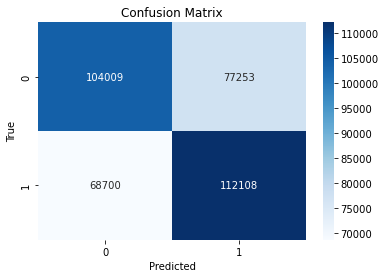

Model: NaiveBayes
Accuracy: 0.5968928660203828
Precision: 0.5971335290350641
Recall: 0.5968928660203829
F1 Score: 0.596679756610422
Confusion Matrix:
[[104009.  77253.]
 [ 68700. 112108.]]
[('NaiveBayes', 0.5968928660203828, 0.5971335290350641, 0.5968928660203829, 0.596679756610422)]


In [56]:
naive_report = classification_report(oversampled_df, 'is_fraud',NaiveBayes(labelCol='is_fraud', featuresCol="features"))

print(naive_report)

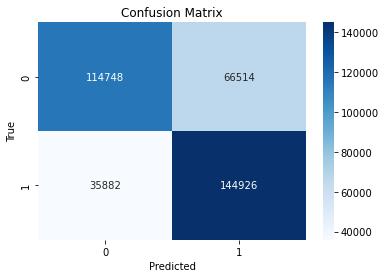

Model: RandomForestClassifier
Accuracy: 0.7171928080205485
Precision: 0.7236533368134648
Recall: 0.7171928080205485
F1 Score: 0.7151846460650771
Confusion Matrix:
[[114748.  66514.]
 [ 35882. 144926.]]
[('RandomForestClassifier', 0.7171928080205485, 0.7236533368134648, 0.7171928080205485, 0.7151846460650771)]


In [57]:
random_forest_report = classification_report(oversampled_df, 'is_fraud',RandomForestClassifier(labelCol='is_fraud', featuresCol="features"))
print(random_forest_report)

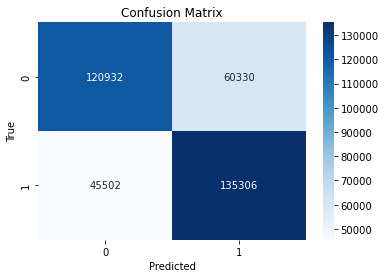

Model: DecisionTreeClassifier
Accuracy: 0.7077029303725799
Precision: 0.70913569220754
Recall: 0.7077029303725799
F1 Score: 0.7072269548653127
Confusion Matrix:
[[120932.  60330.]
 [ 45502. 135306.]]
[('DecisionTreeClassifier', 0.7077029303725799, 0.70913569220754, 0.7077029303725799, 0.7072269548653127)]


In [58]:
decision_tree_report = classification_report(oversampled_df, 'is_fraud',DecisionTreeClassifier(labelCol='is_fraud', featuresCol="features"))
print(decision_tree_report)

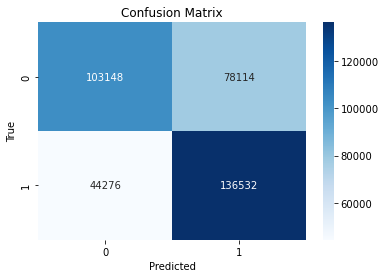

Model: LinearSVC
Accuracy: 0.6619714419863563
Precision: 0.6679142937443119
Recall: 0.6619714419863563
F1 Score: 0.659033661974838
Confusion Matrix:
[[103148.  78114.]
 [ 44276. 136532.]]
[('LinearSVC', 0.6619714419863563, 0.6679142937443119, 0.6619714419863563, 0.659033661974838)]


In [61]:
svc_report = classification_report(oversampled_df, 'is_fraud',LinearSVC(labelCol='is_fraud', featuresCol="features"))
print(svc_report)

## Visualizations

In [62]:
vis_df1 = new_df1
vis_df1.show(10)

+----------+--------------------+---------------+------------+----------------+---------------------+
|       npi|           drug_name|total_drug_cost|total_claims|total_day_supply|specialty_description|
+----------+--------------------+---------------+------------+----------------+---------------------+
|1003000126| Amlodipine Besylate|          59.21|          13|             390|    Internal Medicine|
|1003000126|Atorvastatin Calcium|         259.48|          27|             765|    Internal Medicine|
|1003000126|          Cephalexin|          98.99|          17|             123|    Internal Medicine|
|1003000126|   Ciprofloxacin Hcl|         120.43|          12|              95|    Internal Medicine|
|1003000126| Doxycycline Hyclate|         300.76|          17|             105|    Internal Medicine|
|1003000126|          Furosemide|          97.33|          22|             595|    Internal Medicine|
|1003000126|     Hydralazine Hcl|         169.44|          13|             380|   

In [63]:
vis_df2=new_df2
vis_df2.show(10)

+----------+------------+---------+------------+-----+---------------------+
|       npi|  first_name|last_name|        city|state|specialty_description|
+----------+------------+---------+------------+-----+---------------------+
|1003012014|Keith-Austin|   Scarfo|  Providence|   RI|       Anesthesiology|
|1003014374|     Michael| Connolly|    Riverton|   UT| Psychiatry & Neur...|
|1003015785|        Ryan|   Rogers|     Houston|   TX|        Ophthalmology|
|1003019902|     Lealani|   Acosta|   Nashville|   TN|            Neurology|
|1003023029|    Takehiro| Kasahara|    New York|   NY| Oral Surgery (Den...|
|1003055781|       Jenny|     Rice|    Hartford|   CT|  Physician Assistant|
|1003068628|       Katie|    Smith|   Evergreen|   CO|  Physician Assistant|
|1003077157|     Michael|Sniderman| Los Angeles|   CA|       Anesthesiology|
|1003078254|        Paul|Rutkowski|Wilkes Barre|   PA|    Internal Medicine|
|1003081142|        Neal|   Murphy|      Oxnard|   CA|              Dentist|

In [64]:
vis_df3 = payment_fpd1
vis_df3 = vis_df3.withColumn("Total_Payment_Sum", col("Total_Payment_Sum").cast("float"))

vis_df3.show(10)

+----------+---------+-----------+-----+-----------------+-----+
|first_name|last_name|       city|state|Total_Payment_Sum|index|
+----------+---------+-----------+-----+-----------------+-----+
|      null|     null|     DUARTE|   CA|      4.0083734E8|    0|
|      null|     null|     BOSTON|   MA|      6.5483588E7|    1|
|      null|     null|      PHILA|   PA|      3.3109344E7|    2|
|     JAMES|   GAMMIE|  BALTIMORE|   MD|       2.684353E7|    3|
|   STEPHEN| BURKHART|SAN ANTONIO|   TX|      2.2969246E7|    4|
|   CHARLES|   GOODIS|ALBUQUERQUE|   NM|      2.2880446E7|    5|
|      null|     null|LOS ANGELES|   CA|      1.7430154E7|    6|
|     KEVIN|    FOLEY|    MEMPHIS|   TN|      1.7038512E7|    7|
|      null|     null| HACKENSACK|   NJ|      1.5096584E7|    8|
|      null|     null|     BOSTON|   MA|      1.3539022E7|    9|
+----------+---------+-----------+-----+-----------------+-----+
only showing top 10 rows



In [65]:
vis_df4 = FeaturesAll_df
vis_df4.show(10)

+----------+----------------------+-----------------------+----------------------+-------------------+--------------------+-------------------+-----------------------+------------------------+-----------------------+------------------+-------------------+-------------------+-------------------+--------+
|       npi|sum_of_total_drug_cost|mean_of_total_drug_cost|max_of_total_drug_cost|sum_of_total_claims|mean_of_total_claims|max_of_total_claims|sum_of_total_day_supply|mean_of_total_day_supply|max_of_total_day_supply| Total_Payment_Sum|     claim_max-mean|    supply_max-mean|      drug_max-mean|is_fraud|
+----------+----------------------+-----------------------+----------------------+-------------------+--------------------+-------------------+-----------------------+------------------------+-----------------------+------------------+-------------------+-------------------+-------------------+--------+
|1891993317|     4.711890285188924|     3.2207814564251014|     4.089300208943661|  2

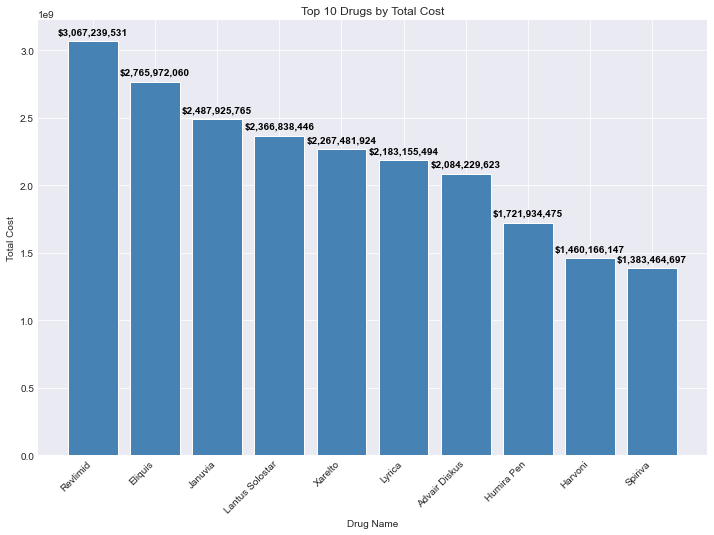

In [86]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

# Get the data
top_drugs = vis_df1.groupBy("drug_name").agg(F.sum("total_drug_cost").alias("total_cost")).orderBy("total_cost", ascending=False).limit(10).toPandas()

# Set the figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the bar chart
ax.bar(top_drugs['drug_name'], top_drugs['total_cost'], color='steelblue')

# Set the axis labels and title
ax.set_xlabel('Drug Name')
ax.set_ylabel('Total Cost')
ax.set_title('Top 10 Drugs by Total Cost')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(top_drugs['total_cost']):
    ax.text(i, v+50000000, f"${v:,.0f}", ha='center', fontweight='bold', color='black')

# Show the plot
plt.show()


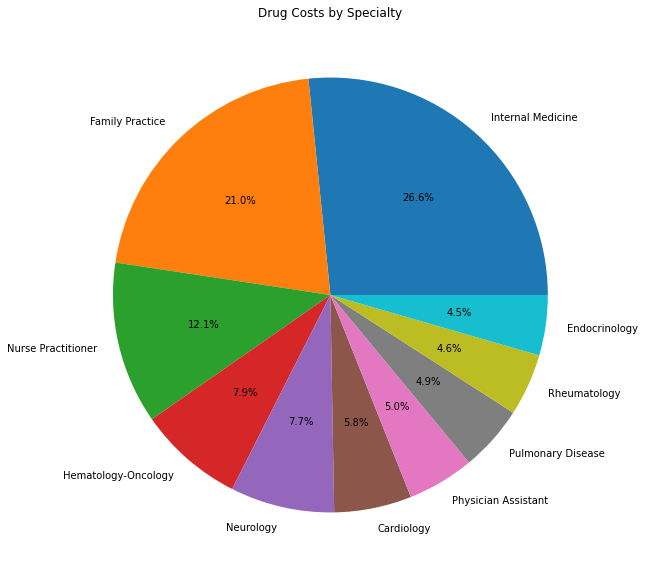

In [67]:
#import matplotlib.pyplot as plt
#import pyspark.sql.functions as F

costs_by_specialty = vis_df1.groupBy("specialty_description").agg(F.sum("total_drug_cost").alias("total_cost")).orderBy("total_cost", ascending=False).limit(10)
costs = costs_by_specialty.select("total_cost").rdd.flatMap(lambda x: x).collect()
specialties = costs_by_specialty.select("specialty_description").rdd.flatMap(lambda x: x).collect()
fig, ax = plt.subplots()
ax.pie(costs, labels=specialties, autopct='%1.1f%%')
ax.set_title('Drug Costs by Specialty')

fig.set_size_inches(10, 10)
plt.show()

In [68]:
vis_df5 = payment_fpd
vis_df5 = vis_df5.withColumn("Total_Amount_of_Payment_USDollars", col("Total_Amount_of_Payment_USDollars").cast("float"))

vis_df5 = vis_df5.na.drop()
vis_df5.show(10)

+----------------------------+---------------------------+--------------+---------------+---------------------------------+
|Covered_Recipient_First_Name|Covered_Recipient_Last_Name|Recipient_City|Recipient_State|Total_Amount_of_Payment_USDollars|
+----------------------------+---------------------------+--------------+---------------+---------------------------------+
|                       NAZEM|                    ABRAHAM|    HUNTINGTON|             WV|                             12.0|
|                     Charles|                        Pak|        Dallas|             TX|                            300.0|
|                       Nazem|                    Abraham|    HUNTINGTON|             WV|                            13.39|
|                       NAZEM|                    ABRAHAM|    HUNTINGTON|             WV|                            13.39|
|                        HANY|                      AHMED|       HOUSTON|             TX|                            12.03|
|       

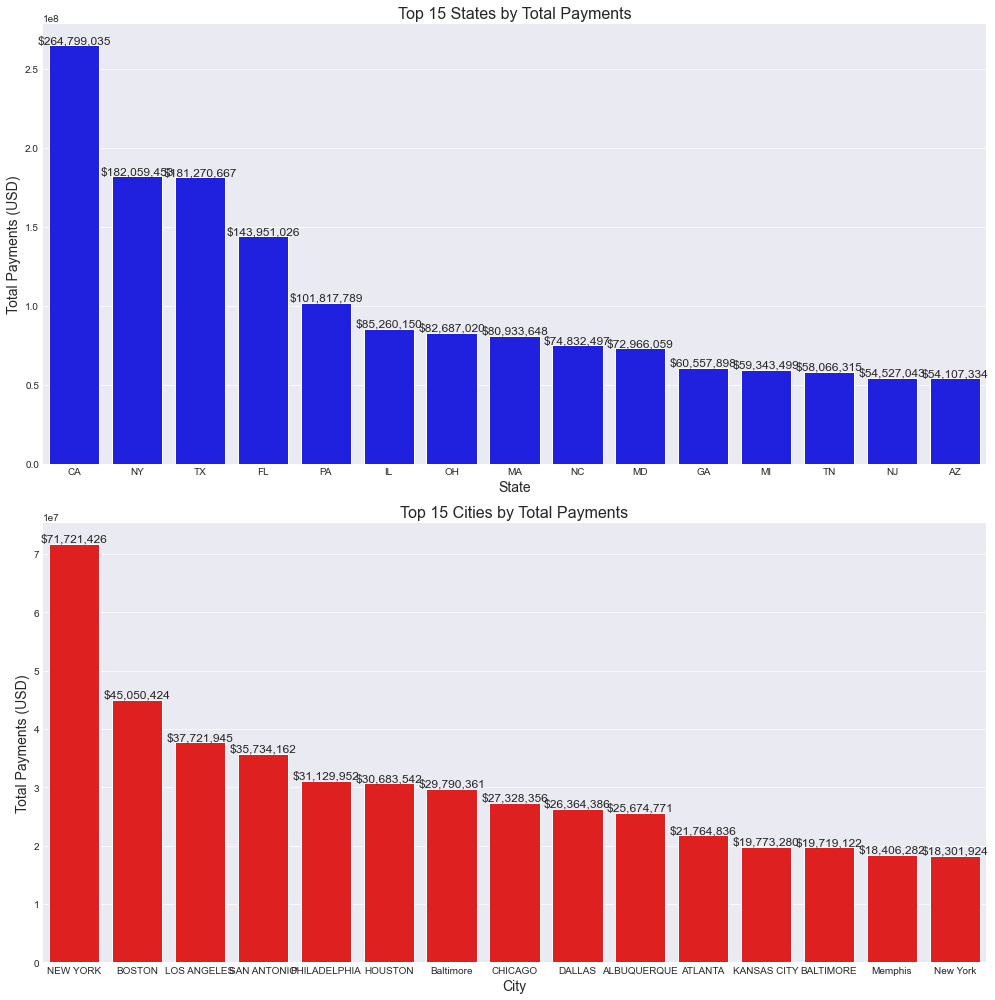

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F

# Group the data by recipient state and city and get the sum of total amount of payment
grouped_data = vis_df5.groupBy("Recipient_State", "Recipient_City").agg(F.sum("Total_Amount_of_Payment_USDollars").alias("Total_Payments"))

# Get the top 15 states and cities by total payments
top_states = grouped_data.groupBy("Recipient_State").agg(F.sum("Total_Payments").alias("Total_Payments")).orderBy("Total_Payments", ascending=False).limit(15)
top_cities = grouped_data.groupBy("Recipient_City").agg(F.sum("Total_Payments").alias("Total_Payments")).orderBy("Total_Payments", ascending=False).limit(15)

# Convert to Pandas dataframes
pd_df_states = top_states.toPandas()
pd_df_cities = top_cities.toPandas()

# Set the plot style
sns.set_style("darkgrid")

# Create the plot
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 14))
sns.barplot(data=pd_df_states, x='Recipient_State', y='Total_Payments', ax=ax1, color='b')
sns.barplot(data=pd_df_cities, x='Recipient_City', y='Total_Payments', ax=ax2, color='r')
ax1.set_xlabel('State', fontsize=14)
ax1.set_ylabel('Total Payments (USD)', fontsize=14)
ax1.set_title('Top 15 States by Total Payments', fontsize=16)
ax2.set_xlabel('City', fontsize=14)
ax2.set_ylabel('Total Payments (USD)', fontsize=14)
ax2.set_title('Top 15 Cities by Total Payments', fontsize=16)

# Add the values on top of the bars
for index, row in pd_df_states.iterrows():
    ax1.text(index, row['Total_Payments'], '${:,.0f}'.format(row['Total_Payments']), 
            ha='center', va='bottom', fontsize=12)
for index, row in pd_df_cities.iterrows():
    ax2.text(index, row['Total_Payments'], '${:,.0f}'.format(row['Total_Payments']), 
            ha='center', va='bottom', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


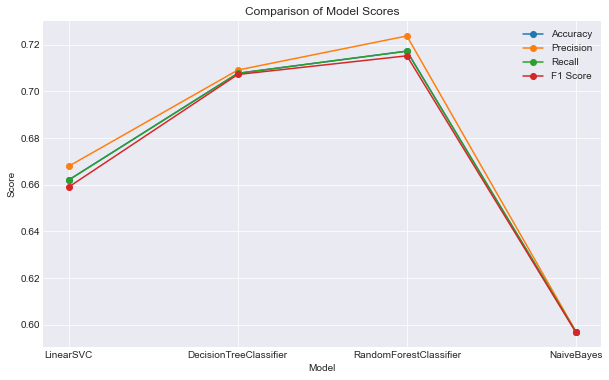

In [71]:
import matplotlib.pyplot as plt

# Set the style of the plot
plt.style.use('seaborn-darkgrid')

# Define the models and their respective scores
models = []
accuracy = []
precision = []
recall = []
f1_score = []

for report in [svc_report, decision_tree_report, random_forest_report, naive_report]:
    models.append(report[0][0])
    accuracy.append(round(report[0][1], 4))
    precision.append(round(report[0][2], 4))
    recall.append(round(report[0][3], 4))
    f1_score.append(round(report[0][4], 4))

# Set the figure size
fig = plt.figure(figsize=(10, 6))

# Plot the accuracy scores
plt.plot(models, accuracy, label='Accuracy', marker='o')

# Plot the precision scores
plt.plot(models, precision, label='Precision', marker='o')

# Plot the recall scores
plt.plot(models, recall, label='Recall', marker='o')

# Plot the F1 scores
plt.plot(models, f1_score, label='F1 Score', marker='o')

# Add a title and axis labels
plt.title('Comparison of Model Scores')
plt.xlabel('Model')
plt.ylabel('Score')

# Set the legend and show the plot
plt.legend()
plt.show()


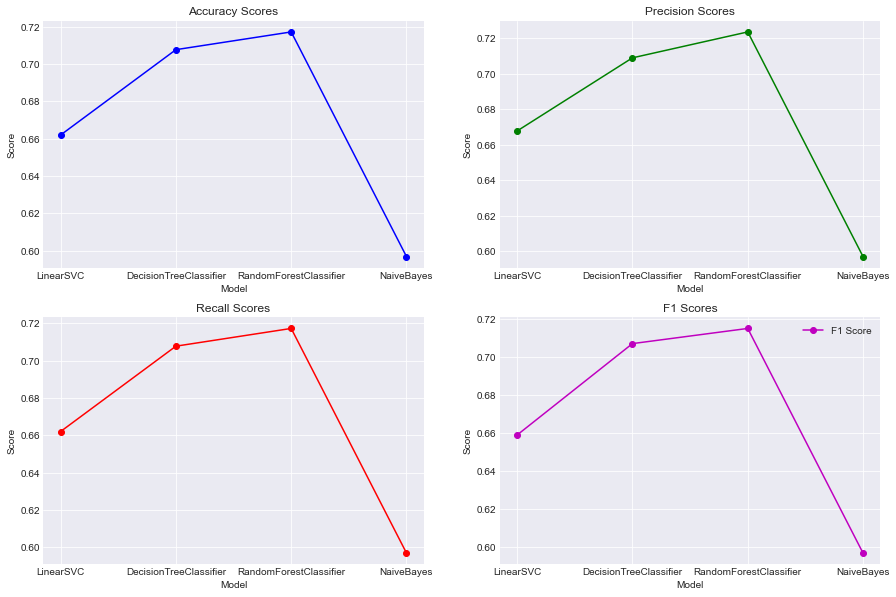

In [72]:
import matplotlib.pyplot as plt

# Set the style of the plot
plt.style.use('seaborn-darkgrid')

# Define the models and their respective scores
models = []
accuracy = []
precision = []
recall = []
f1_score = []

for report in [svc_report, decision_tree_report, random_forest_report, naive_report]:
    models.append(report[0][0])
    accuracy.append(round(report[0][1], 4))
    precision.append(round(report[0][2], 4))
    recall.append(round(report[0][3], 4))
    f1_score.append(round(report[0][4], 4))

# Set the figure size
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axs = axs.flatten()

# Plot the accuracy scores
axs[0].plot(models, accuracy, label='Accuracy', marker='o', color='b')

# Plot the precision scores
axs[1].plot(models, precision, label='Precision', marker='o', color='g')

# Plot the recall scores
axs[2].plot(models, recall, label='Recall', marker='o', color='r')

# Plot the F1 scores
axs[3].plot(models, f1_score, label='F1 Score', marker='o', color='m')

# Add a title and axis labels for each subplot
axs[0].set_title('Accuracy Scores')
axs[0].set_xlabel('Model')
axs[0].set_ylabel('Score')

axs[1].set_title('Precision Scores')
axs[1].set_xlabel('Model')
axs[1].set_ylabel('Score')

axs[2].set_title('Recall Scores')
axs[2].set_xlabel('Model')
axs[2].set_ylabel('Score')

axs[3].set_title('F1 Scores')
axs[3].set_xlabel('Model')
axs[3].set_ylabel('Score')

# Set the legend and show the plot
plt.legend()
plt.show()


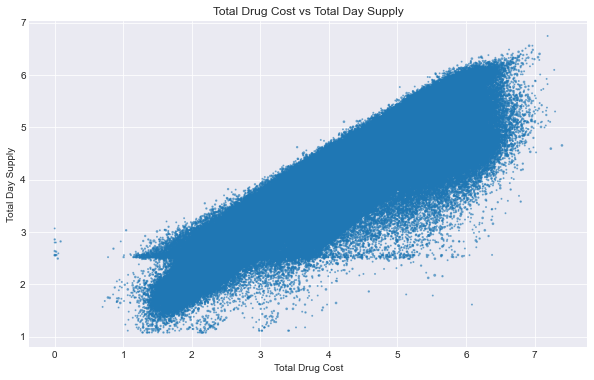

In [74]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

# Group the data by sum of total drug cost and sum of total day supply
grouped_data = vis_df4`.groupBy('sum_of_total_drug_cost', 'sum_of_total_day_supply').agg(F.count('*').alias('count'))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(grouped_data.select('sum_of_total_drug_cost').rdd.flatMap(lambda x: x).collect(),
           grouped_data.select('sum_of_total_day_supply').rdd.flatMap(lambda x: x).collect(),
           s=grouped_data.select('count').rdd.flatMap(lambda x: x).collect(), alpha=0.5)

# Set the axis labels and title
ax.set_xlabel('Total Drug Cost')
ax.set_ylabel('Total Day Supply')
ax.set_title('Total Drug Cost vs Total Day Supply')

# Show the plot
plt.show()


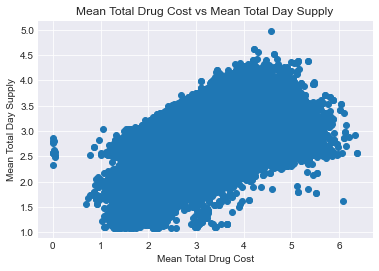

In [92]:
plt.scatter(vis_df4.select("mean_of_total_drug_cost").rdd.flatMap(lambda x: x).collect(),
            vis_df4.select("mean_of_total_day_supply").rdd.flatMap(lambda x: x).collect())
plt.title("Mean Total Drug Cost vs Mean Total Day Supply")
plt.xlabel("Mean Total Drug Cost")
plt.ylabel("Mean Total Day Supply")
plt.show()


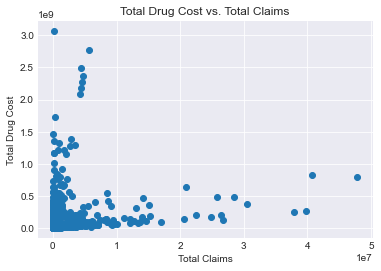

In [94]:
import matplotlib.pyplot as plt

df_agg = vis_df1.groupBy('drug_name').agg(F.sum('total_drug_cost').alias('total_cost'), F.sum('total_claims').alias('total_claims')).toPandas()

plt.scatter(df_agg['total_claims'], df_agg['total_cost'])
plt.xlabel('Total Claims')
plt.ylabel('Total Drug Cost')
plt.title('Total Drug Cost vs. Total Claims')
plt.show()


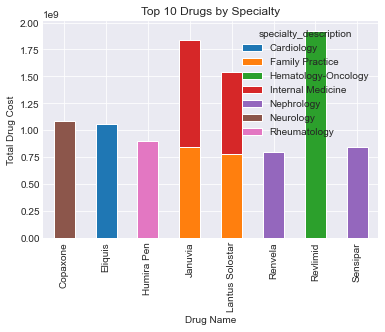

In [98]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

df_agg = vis_df1.groupBy('specialty_description', 'drug_name').agg(F.sum('total_drug_cost').alias('total_cost'))
df_agg = df_agg.orderBy('total_cost', ascending=False).limit(10).toPandas()

pivot_df = df_agg.pivot(index='drug_name', columns='specialty_description', values='total_cost')

pivot_df.plot(kind='bar', stacked=True)
plt.xlabel('Drug Name')
plt.ylabel('Total Drug Cost')
plt.title('Top 10 Drugs by Specialty')
plt.show()


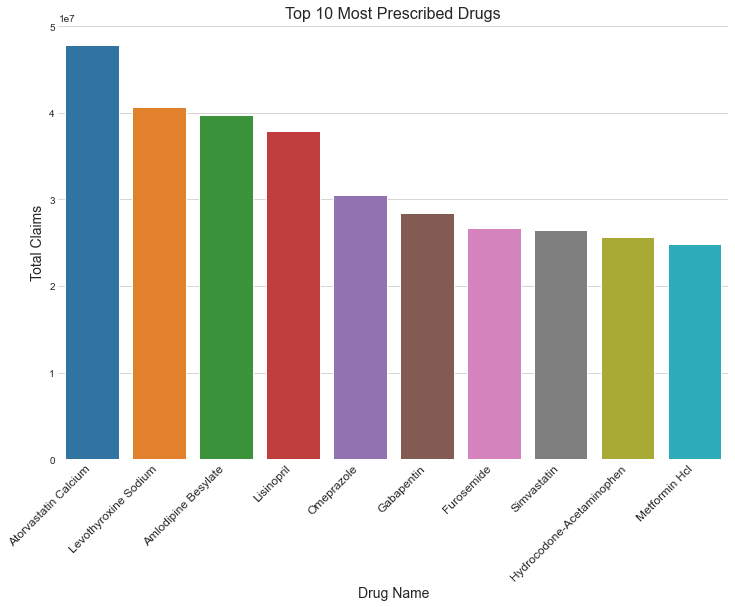

In [101]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate total claims by drug name
df_agg = vis_df1.groupBy('drug_name').agg(F.sum('total_claims').alias('total_claims'))

# Order by total claims and select top 10
df_agg = df_agg.orderBy('total_claims', ascending=False).limit(10).toPandas()

# Create bar plot using seaborn
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.barplot(x='drug_name', y='total_claims', data=df_agg)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.xlabel('Drug Name', fontsize=14)
plt.ylabel('Total Claims', fontsize=14)
plt.title('Top 10 Most Prescribed Drugs', fontsize=16)
plt.show()


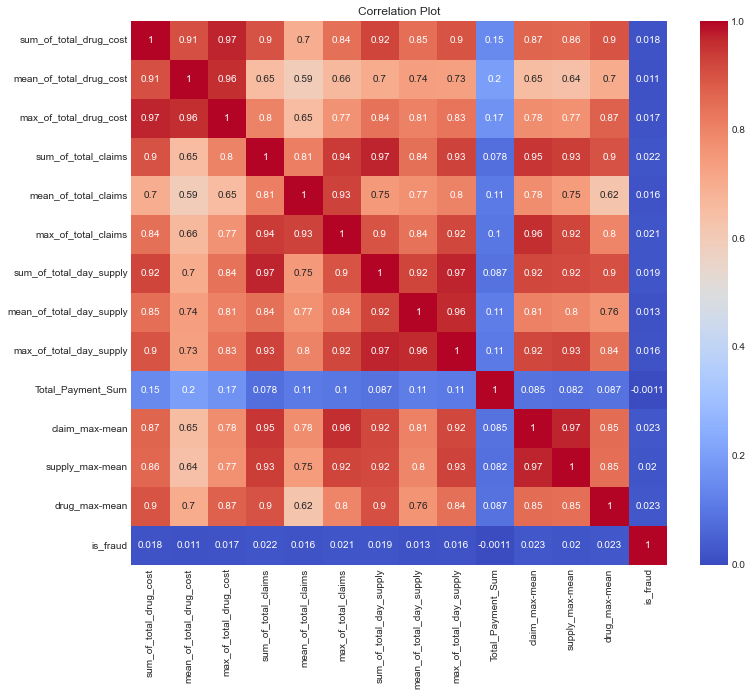

In [102]:
from pyspark.sql.functions import corr
import pyspark.sql.functions as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select the required columns
cols = ['sum_of_total_drug_cost', 'mean_of_total_drug_cost', 'max_of_total_drug_cost', 'sum_of_total_claims',
        'mean_of_total_claims', 'max_of_total_claims', 'sum_of_total_day_supply', 'mean_of_total_day_supply',
        'max_of_total_day_supply', 'Total_Payment_Sum', 'claim_max-mean', 'supply_max-mean', 'drug_max-mean',
        'is_fraud']

# Convert PySpark DataFrame to Pandas DataFrame
df_pd = vis_df4.select(cols).toPandas()

# Compute the correlation matrix
corr_matrix = df_pd.corr()

# Plot the heatmap
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Plot')
plt.show()
